In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K

from dataset import DataGenerator
from SwinUNet import SwinUNet
from ConvUNet import ConvNeXTUNet

In [4]:
train_data = DataGenerator('/content/drive/MyDrive/data/train', batch_size = 64)
val_data = DataGenerator('/content/drive/MyDrive/data/val', batch_size = 64, predicting = True)

In [5]:
@tf.keras.saving.register_keras_serializable()
def dice_coef(y_true, y_pred):
  y_pred = tf.nn.softmax(y_pred)
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.01)

@tf.keras.saving.register_keras_serializable()
def dice_coef_multilabel(y_true, y_pred, numLabels=35):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice

In [6]:
swin_model = SwinUNet(128, 35, window_size = 4, patch_size=4, embed_dim = 96, depths = [2, 2, 6, 2], num_heads = [3, 6, 12, 24], attn_drop_rate = 0.3, proj_drop_rate = 0.3)
swin_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0005, learning_rate = 0.001),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [7]:
swin_history = swin_model.fit(train_data, epochs = 30, validation_data = val_data)

Epoch 1/30
32/32 [==============================] - 322s 8s/step - loss: 0.6164 - accuracy: 0.3621 - dice_coef_multilabel: 0.2240 - val_loss: 1.0393 - val_accuracy: 0.4059 - val_dice_coef_multilabel: 0.2428
Epoch 2/30
32/32 [==============================] - 113s 4s/step - loss: 0.3854 - accuracy: 0.5548 - dice_coef_multilabel: 0.2488 - val_loss: 0.4495 - val_accuracy: 0.5353 - val_dice_coef_multilabel: 0.2452
Epoch 3/30
32/32 [==============================] - 113s 4s/step - loss: 0.3412 - accuracy: 0.6133 - dice_coef_multilabel: 0.2721 - val_loss: 0.3921 - val_accuracy: 0.5862 - val_dice_coef_multilabel: 0.2552
Epoch 4/30
32/32 [==============================] - 113s 4s/step - loss: 0.3192 - accuracy: 0.6755 - dice_coef_multilabel: 0.2876 - val_loss: 0.3699 - val_accuracy: 0.6107 - val_dice_coef_multilabel: 0.2660
Epoch 5/30
32/32 [==============================] - 118s 4s/step - loss: 0.3047 - accuracy: 0.7041 - dice_coef_multilabel: 0.3031 - val_loss: 0.3482 - val_accuracy: 0.6979 

In [8]:
conv_model = ConvNeXTUNet(128, 96, 35, [3, 3, 9, 3])
conv_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0005, learning_rate = 0.001),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [9]:
conv_history = conv_model.fit(train_data, epochs = 30, validation_data = val_data)

Epoch 1/30
32/32 [==============================] - 169s 4s/step - loss: 0.5252 - accuracy: 0.4334 - dice_coef_multilabel: 0.2459 - val_loss: 1.1483 - val_accuracy: 0.3727 - val_dice_coef_multilabel: 0.2648
Epoch 2/30
32/32 [==============================] - 118s 4s/step - loss: 0.3560 - accuracy: 0.6184 - dice_coef_multilabel: 0.2721 - val_loss: 0.5106 - val_accuracy: 0.5376 - val_dice_coef_multilabel: 0.2507
Epoch 3/30
32/32 [==============================] - 117s 4s/step - loss: 0.3266 - accuracy: 0.6815 - dice_coef_multilabel: 0.2889 - val_loss: 0.3705 - val_accuracy: 0.6259 - val_dice_coef_multilabel: 0.2723
Epoch 4/30
32/32 [==============================] - 120s 4s/step - loss: 0.3096 - accuracy: 0.7099 - dice_coef_multilabel: 0.3033 - val_loss: 0.3609 - val_accuracy: 0.6703 - val_dice_coef_multilabel: 0.2863
Epoch 5/30
32/32 [==============================] - 122s 4s/step - loss: 0.2992 - accuracy: 0.7233 - dice_coef_multilabel: 0.3145 - val_loss: 0.3329 - val_accuracy: 0.7022 

In [10]:
os.makedirs('/content/drive/MyDrive/SaveModel/', exist_ok=True)
swin_model.save('/content/drive/MyDrive/SaveModel/swinmodel.keras', save_format="keras")

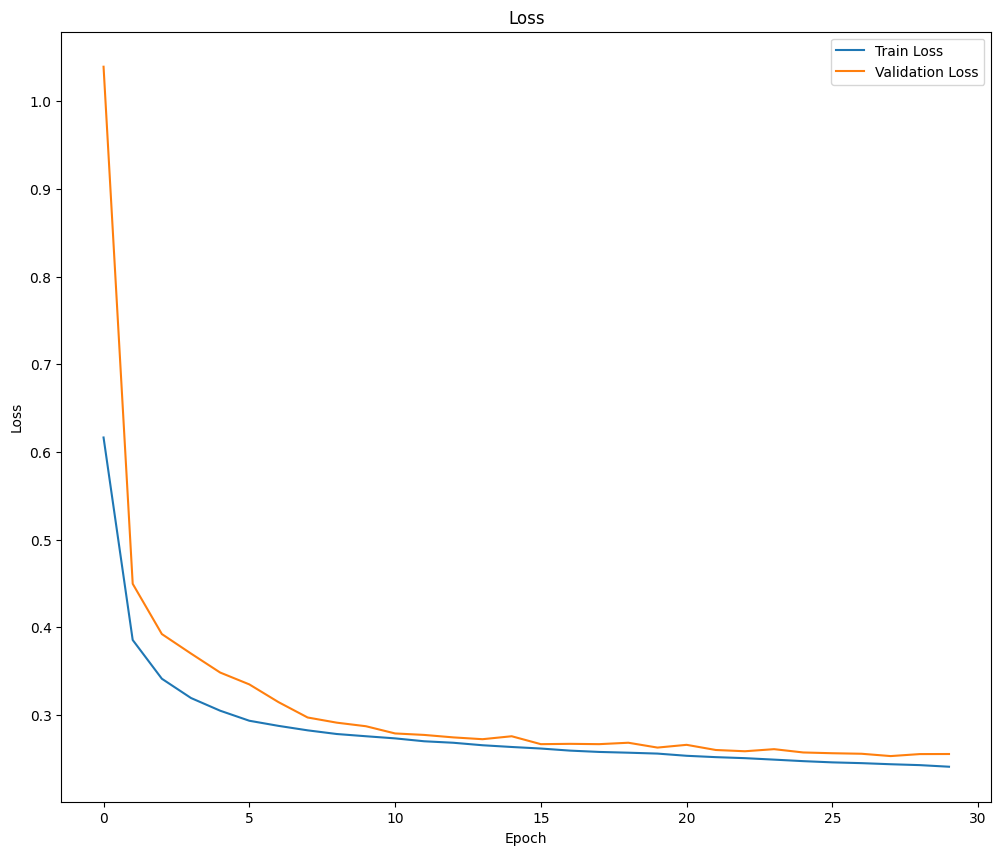

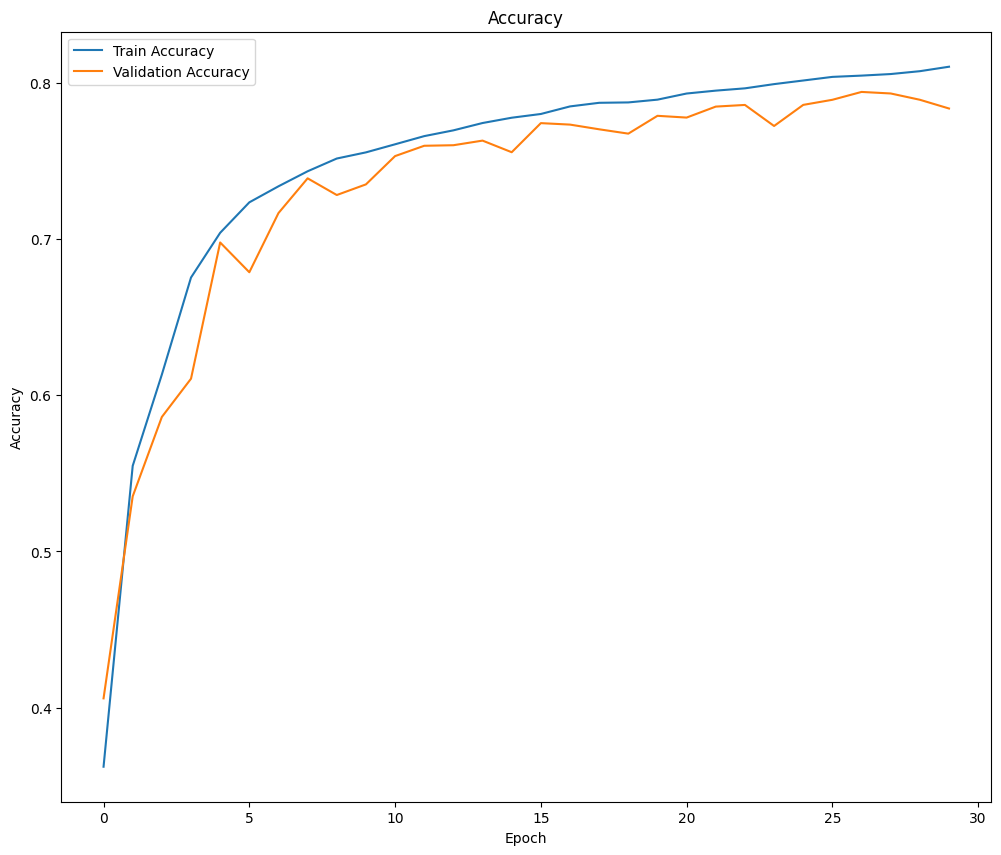

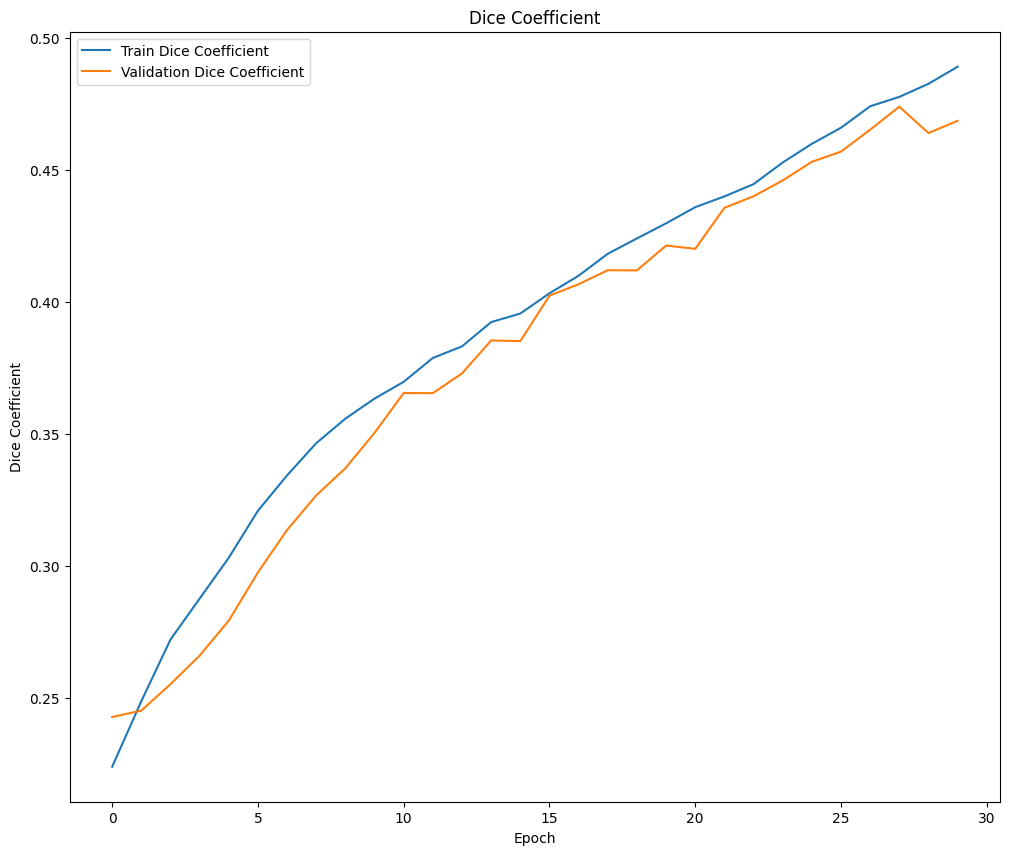

In [11]:
os.makedirs('/content/drive/MyDrive/saveplots/swinmodel', exist_ok=True)

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['loss'], label='Train Loss')
plt.plot(swin_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/swinmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['accuracy'], label='Train Accuracy')
plt.plot(swin_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/swinmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(swin_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/swinmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [12]:
conv_model.save('/content/drive/MyDrive/SaveModel/convnextmodel.keras', save_format="keras")

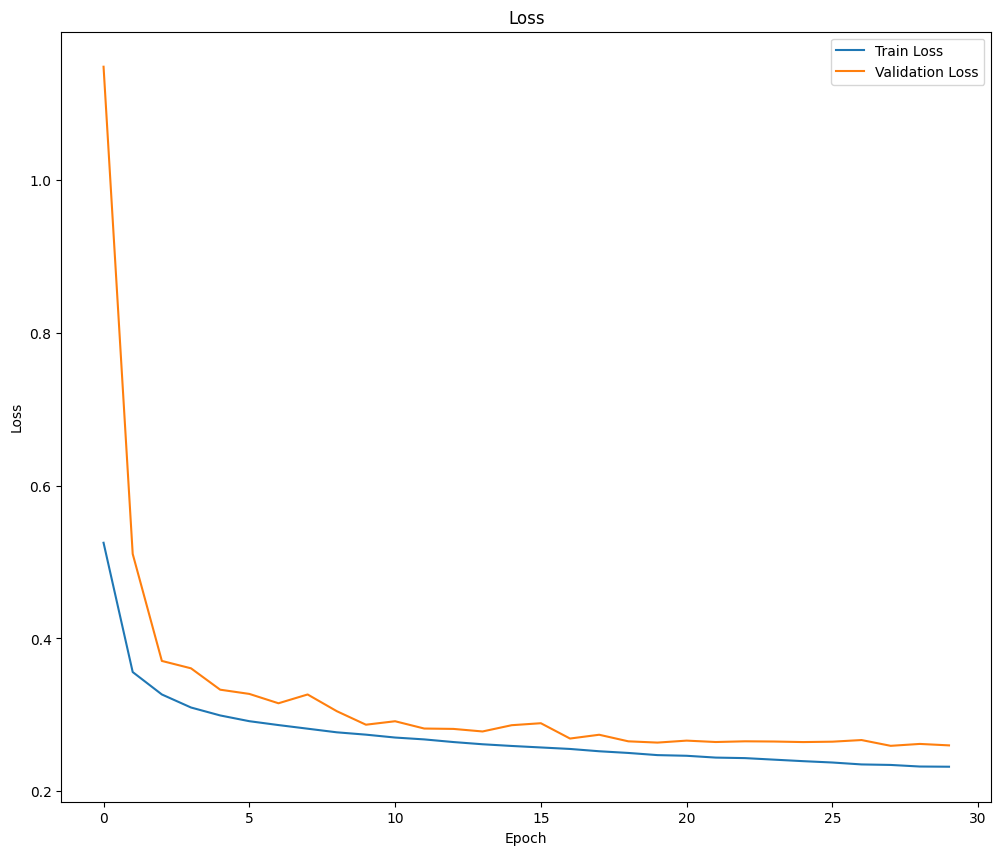

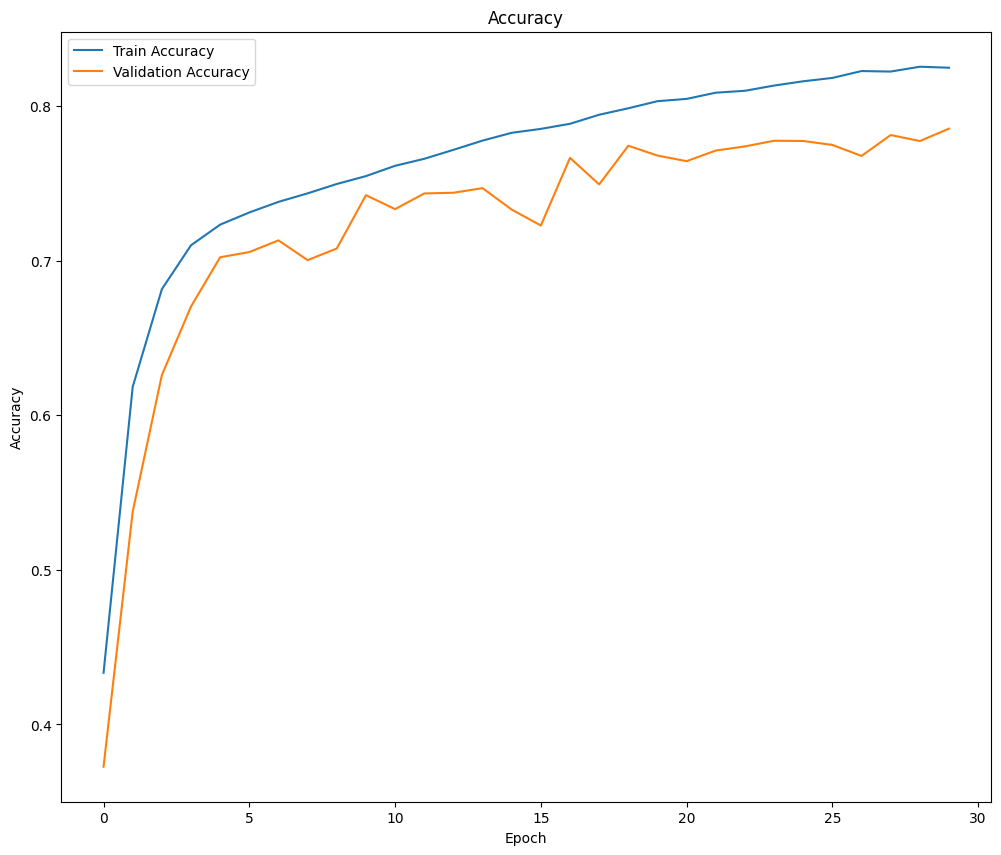

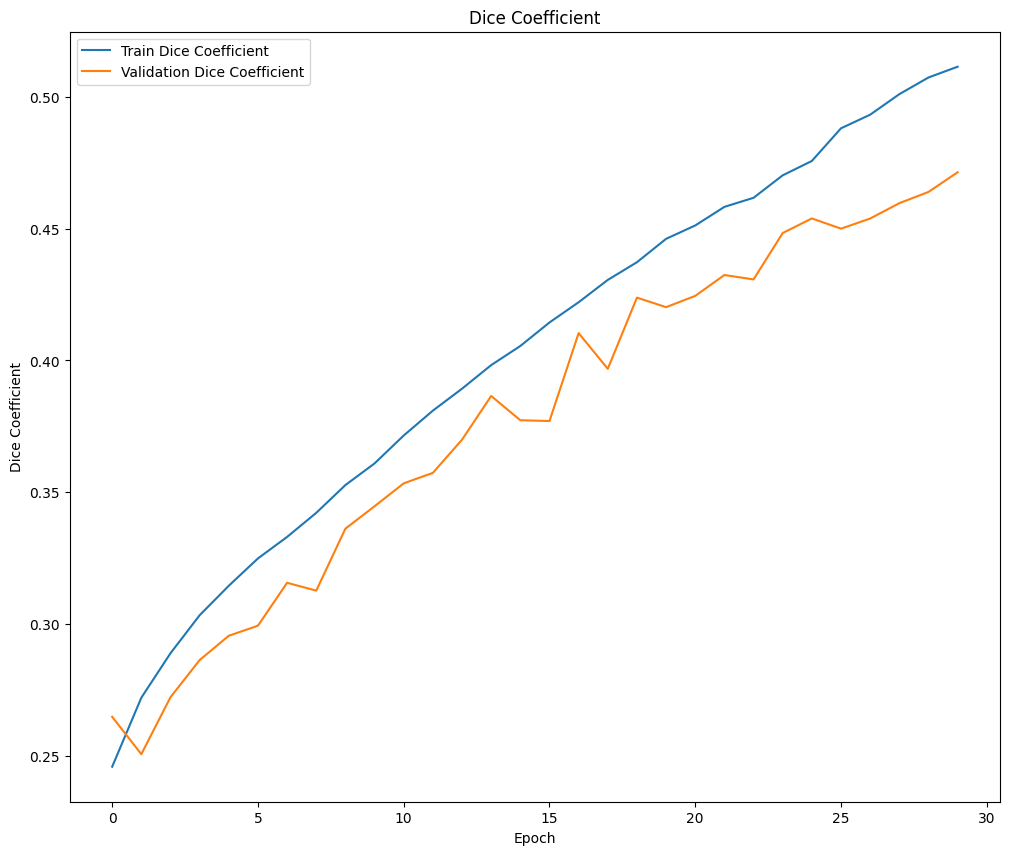

In [18]:
os.makedirs('/content/drive/MyDrive/saveplots/convmodel', exist_ok=True)

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['loss'], label='Train Loss')
plt.plot(conv_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/convmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['accuracy'], label='Train Accuracy')
plt.plot(conv_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/convmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(conv_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/saveplots/convmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [14]:
for img, mask in val_data:
  true_mask = mask[:5]
  imgs = img[:5]
  break

prediction = swin_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

1/1 [==============================] - 5s 5s/step


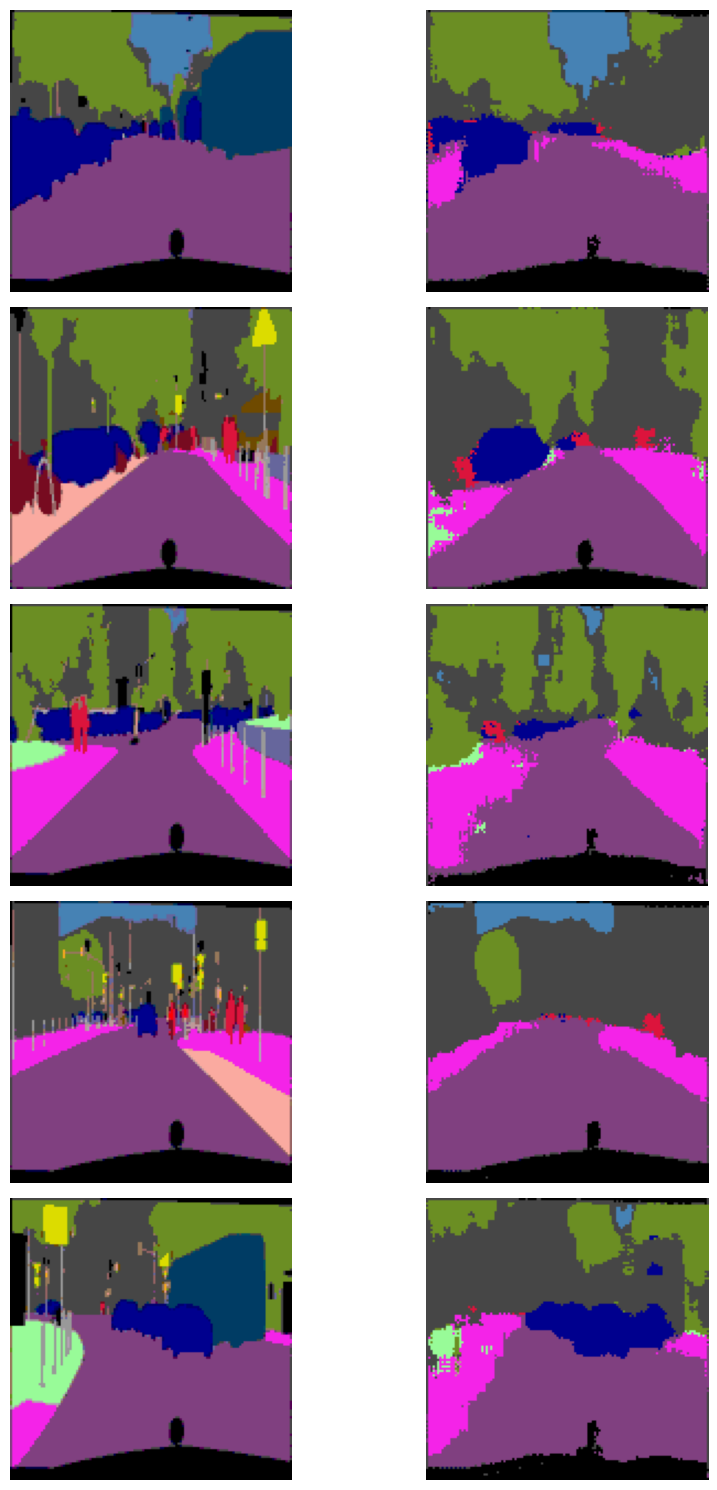

In [15]:
from labeldata import id_to_color
from PIL import Image

fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()



In [16]:
for img, mask in val_data:
  true_mask = mask[:5]
  imgs = img[:5]
  break

prediction = conv_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

1/1 [==============================] - 3s 3s/step


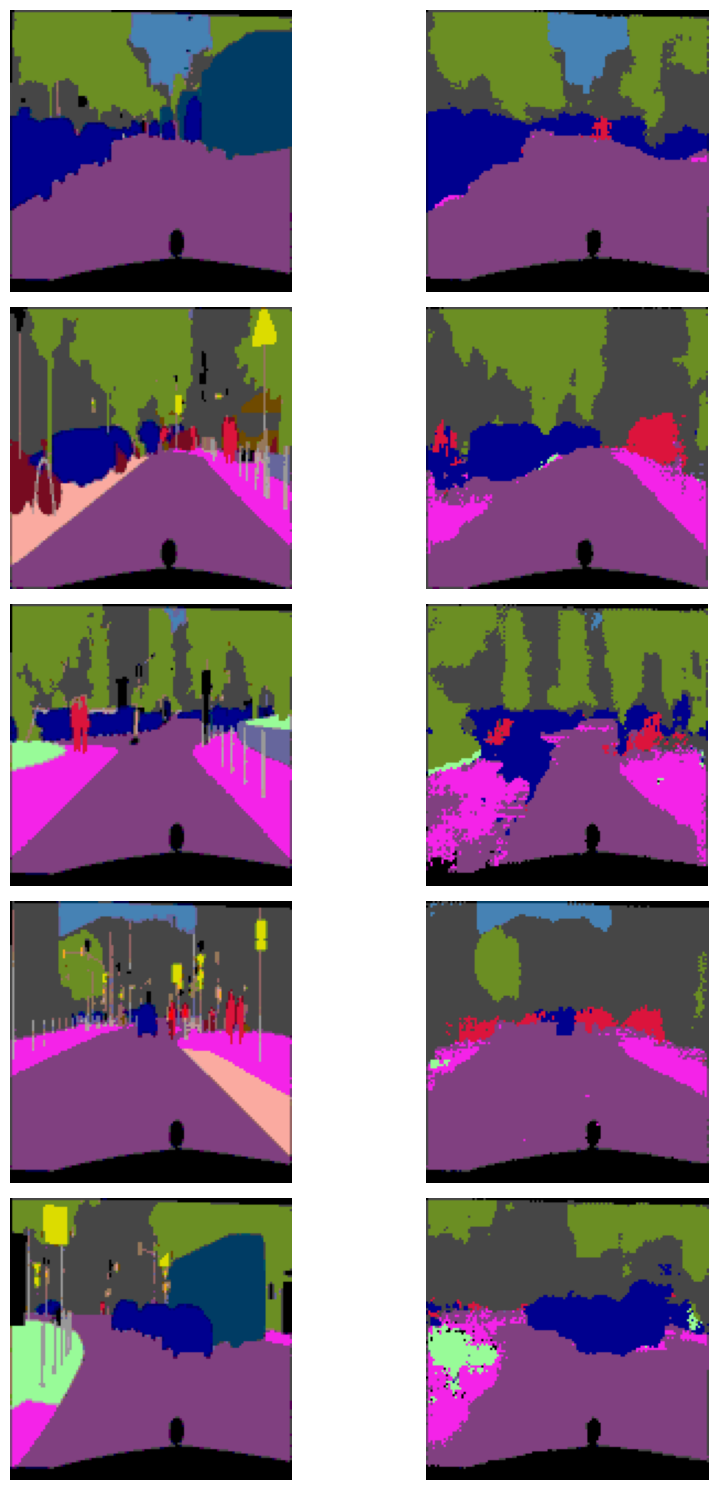

In [17]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()

